# Preamble
## Setup of environment

In [1]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
!pip install voxelmorph

     |████████████████████████████████| 81kB 3.7MB/s 
     |████████████████████████████████| 92kB 4.3MB/s 


In [2]:
# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

Next, we import two packages that will help us   
- [voxelmorph](http://voxelmorph.mit.edu) is a deep-learning based registration library  
- [neurite](https://github.com/adalca/neurite) is a library for medical image analysis with tensorflow  

In [3]:
# local imports
import voxelmorph as vxm
import neurite as ne

---

# Data

## Load & Normalize

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Cardiac Project/Registration_phase/based on doc1/phase_2_voxel_morph/voxelMorph/

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1T4XU2DwFBpucge5DbMQ0wVZaRLkXQ564/Cardiac Project/Registration_phase/based on doc1/phase_2_voxel_morph/voxelMorph


In [6]:
import glob
import imageio

def get_data(moving_imgs_path, fixed_imgs_path, log=False):

    ### load fixed images
    fixed_imgs = []
    if log:
        print("fixed_imgs: ", end="")
    for image_path in glob.glob(fixed_imgs_path):
        image = imageio.imread(image_path)
        i = int(image_path.split('/')[-1].split('_')[0])
        fixed_imgs.append((image, i))
        if log:
            print(i, end=" ")
    fixed_imgs.sort(key=lambda x: x[1])
    fixed_imgs_ = []
    for t in  fixed_imgs:
        fixed_imgs_.append(t[0])
    fixed_imgs = np.array(fixed_imgs_)

    ### load moving images
    moving_imgs = []
    if log:
        print()
        print("moving_imgs: ", end="")
    for image_path in glob.glob(moving_imgs_path):
        image = imageio.imread(image_path)
        i = int(image_path.split('/')[-1].split('_')[0])
        moving_imgs.append((image, i))
        if log:
            print(i, end=" ")
    moving_imgs.sort(key=lambda x: x[1])
    moving_imgs_ = []
    for t in  moving_imgs:
        moving_imgs_.append(t[0])
    moving_imgs = np.array(moving_imgs_)
    if log:
        print()

    # normalize data
    fixed_imgs = fixed_imgs.astype('float')/255
    moving_imgs = moving_imgs.astype('float')/255

    # verify
    if log:
        print('fixed_imgs maximum value', fixed_imgs.max())
        print('moving_imgs maximum value', moving_imgs.max())
    return moving_imgs, fixed_imgs

In [8]:
lge_train, cine_train = get_data("./dataset/lge_images/*.png", "./dataset/cine_images/*.png", log=True)

fixed_imgs: 1 4 5 2 3 6 7 8 9 10 11 12 13 16 15 17 14 19 18 21 20 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 61 62 63 64 65 66 67 60 68 69 70 71 72 73 74 75 77 76 78 79 80 82 81 83 84 85 86 87 88 89 90 91 92 93 94 95 97 96 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 118 117 120 119 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 167 166 168 169 170 171 172 173 174 175 176 177 179 178 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 203 204 202 206 205 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 226 225 227 228 229 230 233 232 231 234 235 236 237 238 239 240 241 242 243 244 245 247 246 248 249 251 252 253 250 254 256 255 257 259 260 258 267 261 268 269 270 262 271 263 264 272 273 265 274 275 

## Visualize

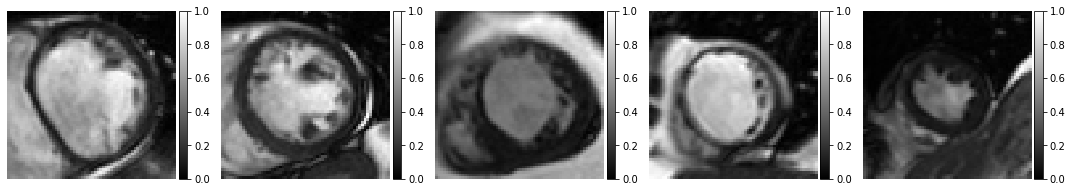

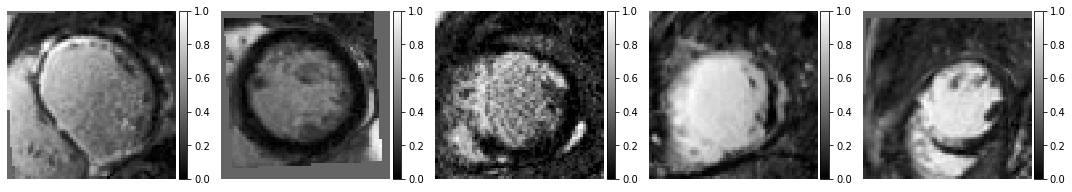

In [9]:
idx = np.random.randint(0, cine_train.shape[0], size=5)

# visualize
cine_examples = [f for f in cine_train[idx, ...]]
lge_examples = [f for f in lge_train[idx, ...]]

ne.plot.slices(cine_examples, cmaps=['gray'], do_colorbars=True);
ne.plot.slices(lge_examples, cmaps=['gray'], do_colorbars=True);

---

# CNN Model

In [10]:
def vxm_data_generator(cine_data, lge_data, batch_size=32, indx=[]):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = cine_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx = np.random.randint(0, cine_data.shape[0], size=batch_size)
        if len(indx) > 0:
          idx = indx
        moving_images = lge_data[idx, ..., np.newaxis]
        fixed_images = cine_data[idx, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [11]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [12]:
def get_model(nb_features, lambda_param, adam_rate, batch_size, epochs, steps_per_epoch):
    inshape = cine_train.shape[1:]
    vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
    losses = [vxm.losses.NCC().loss, vxm.losses.Grad('l2').loss]
    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=adam_rate), loss=losses, loss_weights=[1, lambda_param])
    train_generator = vxm_data_generator(cine_train, lge_train, batch_size=batch_size)
    hist = vxm_model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=2);
    return vxm_model, hist

In [13]:
def show(vxm_model, moving_img, fixed_img, indx):
    for i in indx:
        # get some data
        val_generator = vxm_data_generator(fixed_img, moving_img, batch_size=1, indx=[i])
        val_input, _ = next(val_generator)
        val_pred = vxm_model.predict(val_input)


        # visualize
        images = [img[0, :, :, 0] for img in val_input + val_pred] 
        titles = ['moving', 'fixed', 'moved', 'flow']
        ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# Train Models

In [14]:
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

In [15]:
vxm_models = []
hists = []
for i, lam in enumerate([0.3, 0.4, 0.5, 0.6, 0.7]):
    print()
    print("model number", i, "-----------------------------------------------------------")
    vxm_model, hist = get_model(nb_features, lambda_param=lam, adam_rate=1e-3, batch_size=32, epochs=100, steps_per_epoch=100)
    vxm_models.append(vxm_model)
    hists.append(hist)


model number 0 -----------------------------------------------------------
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 - 45s - loss: -3.2859e-01 - transformer_loss: -3.3530e-01 - flow_loss: 0.0224
Epoch 2/100
100/100 - 13s - loss: -4.0836e-01 - transformer_loss: -4.3596e-01 - flow_loss: 0.0920
Epoch 3/100
100/100 - 13s - loss: -4.4278e-01 - transformer_loss: -4.7983e-01 - flow_loss: 0.1235
Epoch 4/100
100/100 - 13s - loss: -4.6265e-01 - transformer_loss: -5.0575e-01 - flow_loss: 0.1437
Epoch 5/100
100/100 - 13s - loss: -4.8616e-01 - transformer_loss: -5.3194e-01 - flow_loss: 0.1526
Epoch 6/100
100/100 - 13s - loss: -4.9312e-01 - transformer_loss: -5.4193e-01 - flow_loss: 0.1627
Epoch 7/100
100/100 - 13s - loss: -5.0286e-01 - transformer_loss: -5.5406e-01 - flow_loss: 0.1707
Epoch 8/100
100/100 - 13s - loss: -5.1260e-01 - transformer_loss: -5.6535e-01 - flow_loss: 0.1758
Epoch 9/100
100/100 - 13s - loss: -5.2060e-01 - transformer_loss: -5.7479e-01 - flow_loss: 0.1806
Epoch 10/100
100/100 - 13s - loss: -5.2667e-01 - transformer_loss: -5.8200e-01 - flow_loss: 0.1844
Epoch 11/100
100/10

# Show Results

model number 1 : 


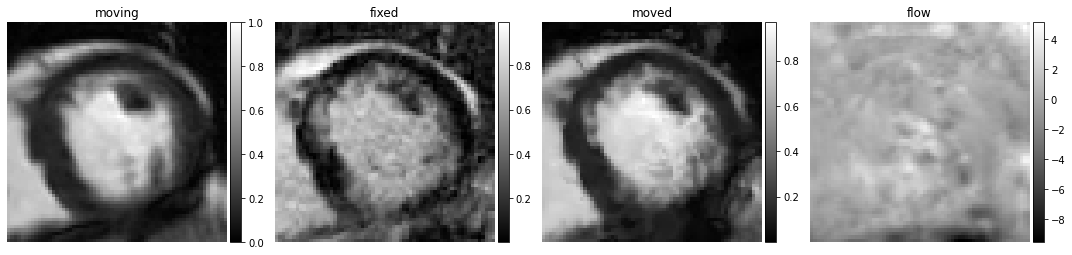

model number 2 : 


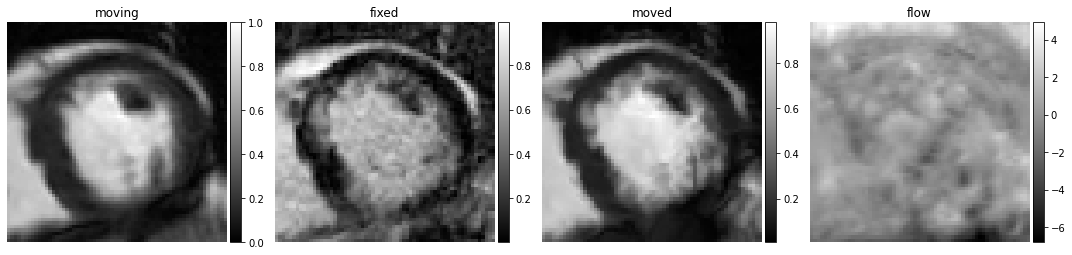

model number 3 : 


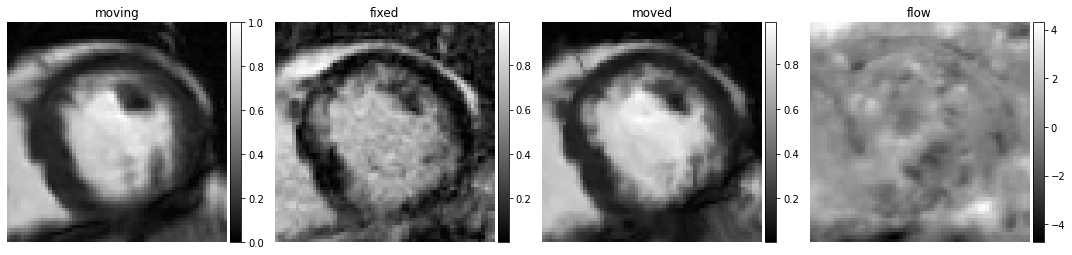

model number 4 : 


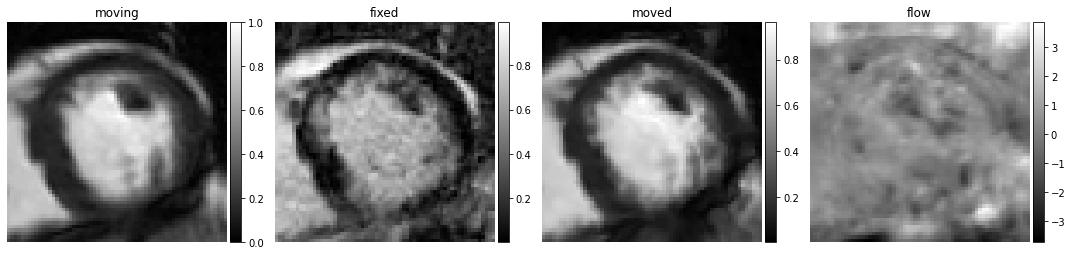

model number 5 : 


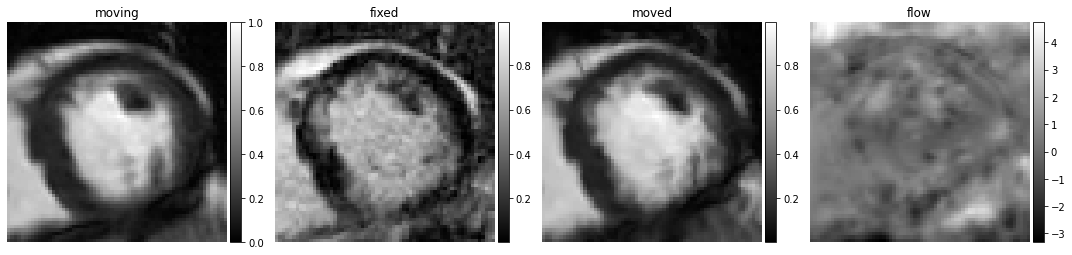

In [22]:
indx = np.random.randint(0, cine_train.shape[0], size=1)
for i, vxm_model in enumerate(vxm_models):
    print("model number", i+1, ": ")
    show(vxm_model=vxm_model, moving_img=cine_train, fixed_img=lge_train, indx=indx)

model number 1 : 


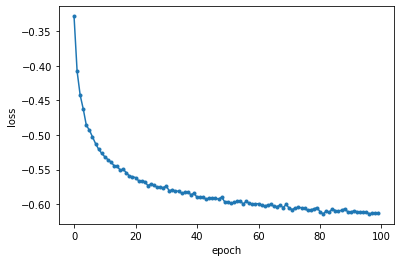

-0.6122933626174927
model number 2 : 


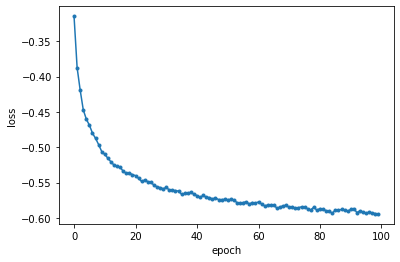

-0.5944633483886719
model number 3 : 


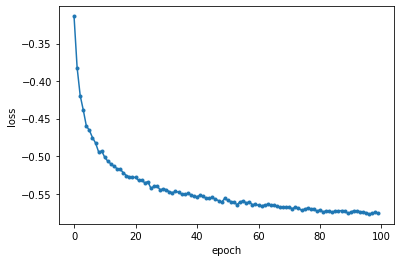

-0.576009213924408
model number 4 : 


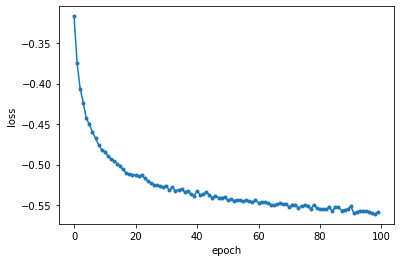

-0.5582905411720276
model number 5 : 


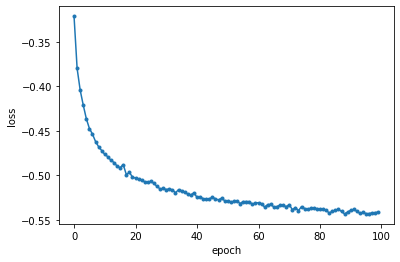

-0.5412871241569519


In [23]:
for i, hist in enumerate(hists):
    print("model number", i+1, ": ")
    plot_history(hist)
    print(hist.history['loss'][-1])

# Registration on Scar

model number 1 : 


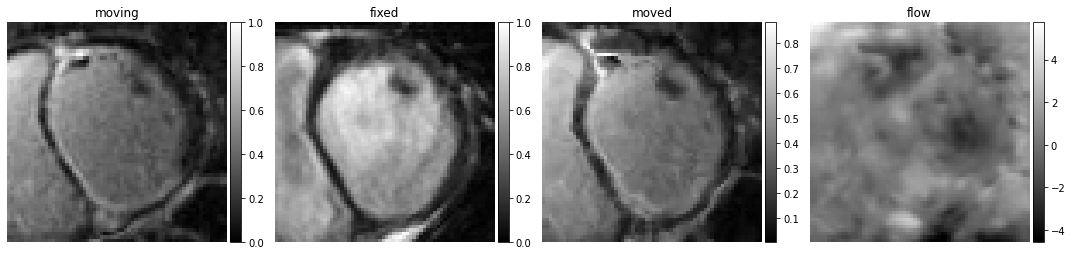

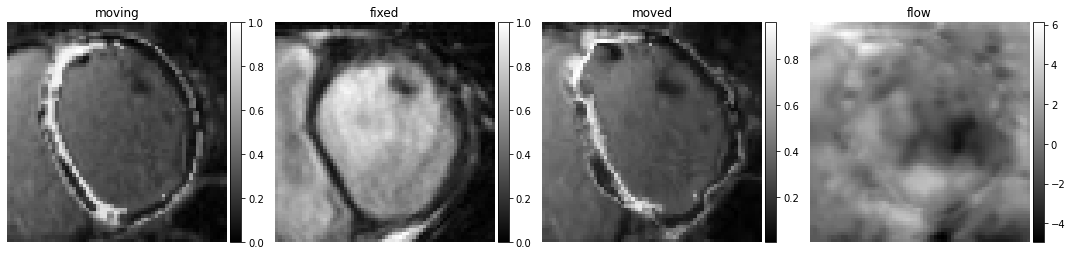

In [ ]:
moving, fixed = get_data("./scar_images/lge_images/*.png", "./scar_images/cine_images/*.png")
indx = [0, 1]
for i, vxm_model in enumerate(vxm_models):
    print("model number", i+1, ": ")
    show(vxm_model=vxm_model, moving_img=moving, fixed_img=fixed, indx=indx)

model number 1 : 


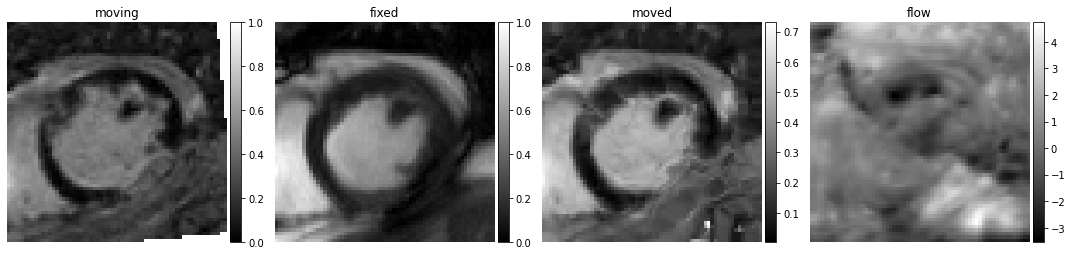

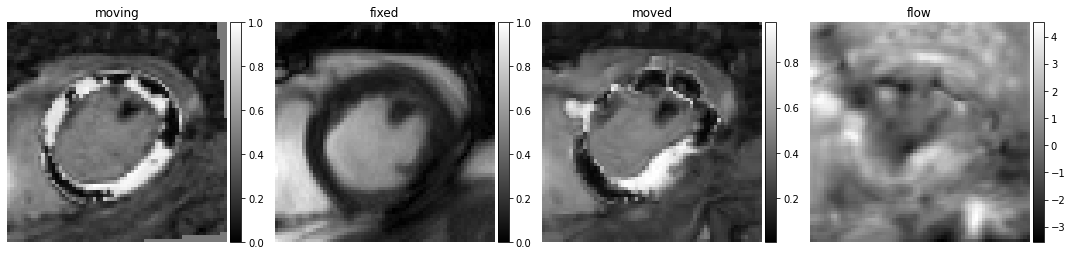

In [ ]:
indx = [2, 3]
for i, vxm_model in enumerate(vxm_models):
    print("model number", i+1, ": ")
    show(vxm_model=vxm_model, moving_img=moving, fixed_img=fixed, indx=indx)